In [ ]:
import pandas as pd
import torch
import numpy as np
import csv
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer,LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
import math
import logging
from datetime import datetime
import os
import gzip
from scipy.stats import pearsonr
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.stats import pearsonr


c:\Users\SAUMIL\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def df_clean(df):
    df_l = df.values.tolist()
    df_new = []
    c=0
    for i in df_l:
        # print(i)
        c=0
        for j in range(0,len(i)):
            if('main-news' in str(i[j]) or 'main-forum' in str(i[j])):
                c=1
                continue
        if(c==0):
            if (pd.isnull(i[0]) or pd.isnull(i[1]) or pd.isnull(i[2])):
                continue
            df_new.append(i)
    df_new = pd.DataFrame(df_new, columns = ['score', 'sentence1', 'sentence2'])
    # df_new.to_csv('df_new.csv',index=False)
    return df_new

In [ ]:
df_train = df_clean(pd.read_csv('train.csv', delimiter='\t'))  #training dataset
df_val = df_clean(pd.read_csv('dev.csv', delimiter='\t'))      #validation dataset

SETUP 1B (Pearson Score on the validation set)

In [ ]:
model_one = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:

sentences_1 = df_val['sentence1'].tolist()
sentences_2 = df_val['sentence2'].tolist()

In [ ]:

sentence_embeddings_1 = model_one.encode(sentences_1, convert_to_tensor=True)
sentence_embeddings_2 = model_one.encode(sentences_2, convert_to_tensor=True)

s = sentence_embeddings_1+sentence_embeddings_2
max_len = max(len(sent.split()) for sent in sentences_1 + sentences_2)
# print(max_len)
sentence_embeddings_1 = pad_sequences(sentence_embeddings_1, maxlen=max_len,dtype='float32', padding='post')
sentence_embeddings_2 = pad_sequences(sentence_embeddings_2, maxlen=max_len,dtype='float32', padding='post')


cos_sim = util.cos_sim(sentence_embeddings_1, sentence_embeddings_2)
scaled_cos_sim = 0.5 * (cos_sim + 1)
cos_sim = scaled_cos_sim

cosine_similarity = np.diag(cos_sim)
# cosine_similarity


In [ ]:
print(cos_sim)

tensor([[0.9941, 0.7760, 0.5253,  ..., 0.3391, 0.5020, 0.4753],
        [0.7302, 0.9833, 0.6257,  ..., 0.3771, 0.4985, 0.4927],
        [0.5759, 0.6277, 0.9937,  ..., 0.4217, 0.5197, 0.4347],
        ...,
        [0.4688, 0.4450, 0.4158,  ..., 0.8034, 0.4113, 0.6289],
        [0.3014, 0.4351, 0.5382,  ..., 0.5072, 0.6040, 0.5290],
        [0.5686, 0.5581, 0.4975,  ..., 0.6030, 0.5496, 0.6777]])


In [ ]:
print(scaled_cos_sim)

[[0.9941106  0.7759907  0.52534336 ... 0.33907482 0.501984   0.47529766]
 [0.73015827 0.98330057 0.62572706 ... 0.37705588 0.4985443  0.4927244 ]
 [0.5759491  0.6277478  0.9936855  ... 0.42171824 0.519689   0.4347225 ]
 ...
 [0.4687611  0.444985   0.41583097 ... 0.80338967 0.41127694 0.62891895]
 [0.30137578 0.43505016 0.5382189  ... 0.50723714 0.6040071  0.5289912 ]
 [0.5686363  0.55813444 0.4975246  ... 0.6030007  0.54959154 0.67772806]]


In [ ]:
scores = df_val['score'].tolist()
scores = [i/5 for i in scores]  #normalizing the scores
scores = np.array(scores)
scaled_cos_sim= scaled_cos_sim.cpu().numpy()
correlation, p_value = pearsonr(cosine_similarity, scores)
print("Pearson Score is :",correlation)


Pearson Score is : 0.7920248413077999


SETUP 1C

In [ ]:
# Read the dataset
model_name = "all-MiniLM-L6-v2"
train_batch_size = 16
num_epochs = 5
model = SentenceTransformer(model_name)

In [ ]:
def input_example(df):
    out = []
    s1 = df['sentence1'].tolist()
    s2 = df['sentence2'].tolist()
    score = df['score'].tolist()
    for i in range(len(s1)):
        if(type(s1[i])!=str or type(s2[i])!=str or type(score[i])!=float):
            continue
        s = InputExample(texts=[s1[i], s2[i]], label=float(score[i])/5.0)
        out.append(s)
        # print(s)
    return out



In [ ]:
train_data  = input_example(df_train)
dev_data = input_example(df_val)

In [ ]:
from sentence_transformers import SentenceTransformer, evaluation
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16)
val_dataloader = DataLoader(dev_data, shuffle=False, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model=model)

from sentence_transformers import losses
from torch.nn import MSELoss

# Define the CosineSimilarityLoss with desired parameters
# loss_fct = losses.CosineSimilarityLoss(model=model, loss_fct=MSELoss())
s1 = df_val['sentence1'].tolist()
s2 = df_val['sentence2'].tolist()
scores = df_val['score'].tolist()
scores = [i/5 for i in scores]  #normalizing the scores

st1 = df_train['sentence1'].tolist()
st2 = df_train['sentence2'].tolist()
sts = df_train['score'].tolist()
sts = [i/5 for i in sts]  #normalizing the scores


evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_data, name="sts-dev")
evaluator1 = evaluation.EmbeddingSimilarityEvaluator(s1, s2, scores)
evaluator2 = evaluation.EmbeddingSimilarityEvaluator(st1, st2, sts)
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data for warm-up

In [ ]:

#evaluator1 is for validation set
#evaluator2 is for training set
t_loss=[]
v_loss=[]
evaluators = [evaluator1, evaluator2]
for i in range(num_epochs):
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        evaluator=evaluator,
        epochs=1,
        evaluation_steps=1000,
        warmup_steps=warmup_steps,
        optimizer_params={'lr': 2e-6}
    )
    # # Run the evaluation
    validation_loss = evaluator1(model)
    v_loss.append(validation_loss)
    # print(f"Validation Loss: {validation_loss}")

    training_loss = evaluator2(model)
    t_loss.append(training_loss)
    # print(f"Training Loss: {training_loss}")
# # calculate the loss on validation set
# evaluator(model, val_dataloader)
# # print("Epoch",i+1,"completed")





Epoch: 100%|██████████| 1/1 [03:35<00:00, 215.39s/it]


In [ ]:
model.save("Task1Cmodel")

In [ ]:
model = SentenceTransformer("Task1Cmodel")

In [ ]:

# df_stest = pd.read_csv('sample_demo.csv', delimiter='\t')
val_embeddings1 = model.encode(sentences_1, convert_to_tensor=True)
val_embeddings2 = model.encode(sentences_2, convert_to_tensor=True)

# s = val_embeddings1+val_embeddings2
# max_len_1 = max(len(sent.split()) for sent in val_embeddings1 + val_embeddings2)
# print(max_len_1)
val_embeddings1 = pad_sequences(val_embeddings1, maxlen=max_len,dtype='float32', padding='post')
val_embeddings2 = pad_sequences(val_embeddings2, maxlen=max_len,dtype='float32', padding='post')

cos_sim = util.cos_sim(val_embeddings1, val_embeddings2)
scaled_cos_sim = 0.5 * (cos_sim + 1)
cos_sim = scaled_cos_sim
cosine_similarity = np.diag(cos_sim)

scores = df_val['score'].tolist()
scores = [i/5 for i in scores]
scores = np.array(scores)

correlation, p_value = pearsonr(cosine_similarity, scores)
print("Pearson Score is :",correlation)


Pearson Score is : 0.8126659569980687


GRAPHS

Training Losses are : [0.955037711769203, 0.9563387226912187, 0.9575358061674726, 0.9587875078025272, 0.9598743902807635]
Validation Losses are : [0.8950507707933797, 0.8947284783310732, 0.8946393427999483, 0.894527893976277, 0.8944039102402532]


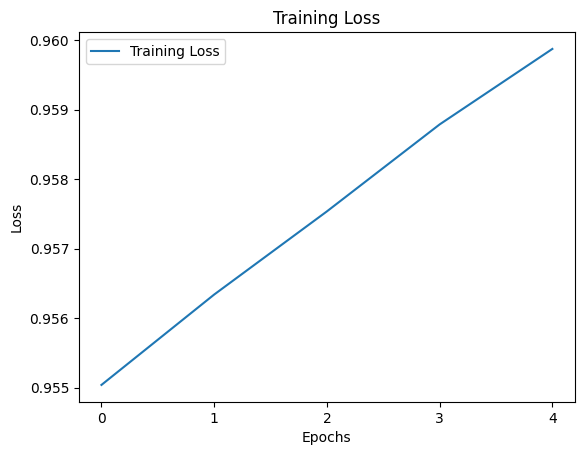

In [ ]:
print("Training Losses are :",t_loss)
print("Validation Losses are :",v_loss)

#give code to plot the graph of training and validation losses vs epochs
import matplotlib.pyplot as plt
plt.plot(t_loss, label='Training Loss')
# plt.plot(v_loss, label='Validation Loss')
#make the x scale as epochs
plt.xticks(range(0, num_epochs))
# rescale the y-axis for values
# plt.ylim(0.4, 1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()